In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Use inspector to see what's in the table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [51]:
# Display the row's columns and data in dictionary format
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a5cb990be0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
engine.execute('select max(date) FROM measurement').fetchall()


[('2017-08-23',)]

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# since the most recent measurement was 2017-08-23 a filter is placed to include that date through the same day a year before

precipitation = session.query(measurement.date, measurement.prcp).filter(measurement.date >= "2016-08-23").\
    filter(measurement.date <= "2017-08-23").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns = ['date', 'prcp']).set_index('date')

# Sort the dataframe by date (and drop NaN)
precipitation_sort = precipitation_df.sort_values(by ='date').dropna()

precipitation_sort.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


Text(0.5, 1.0, 'Precipitation (inches) in last year of measurements')

<Figure size 432x288 with 0 Axes>

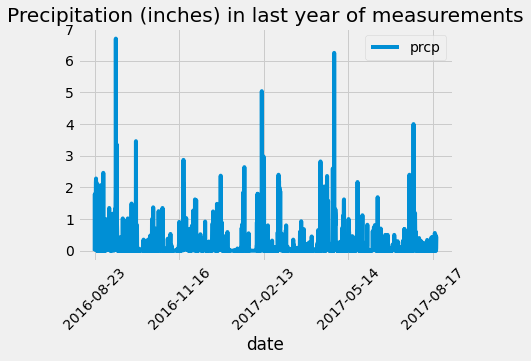

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
precipitation_sort.plot(rot=45)
plt.title("Precipitation (inches) in last year of measurements") 

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_sort.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(station.name).count()
print(f'There are {stations} stations in the dataset.')

There are 9 stations in the dataset.


In [43]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# Use stations column in the measurements table, count and group by station name, order by count descending and show all

active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()

# List the stations and the counts in descending order.
active_stations_df = pd.DataFrame(active_stations, columns = ['Station ID', 'Count'])
active_stations_df

,Station ID,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [60]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature (tobs).
max_station = 'USC00519281'
max_station_info = session.query(func.min(measurement.tobs),
              func.max(measurement.tobs),
              func.avg(measurement.tobs)).filter(measurement.station == max_station).all()
max_station_df = pd.DataFrame(max_station_info, columns = ['Lowest Temp', 'Highest Temp', 'Avg. Temp'])
max_station_name = session.query(station.name).filter(station.station == 'USC00519281').all()

print(f'Details from station USC00519281 {max_station_name}:')
max_station_df

Details from station USC00519281 [('WAIHEE 837.5, HI US',)]:


,Lowest Temp,Highest Temp,Avg. Temp
0,54.0,85.0,71.663781


Text(0.5, 0, 'Temperature (F)')

<Figure size 432x288 with 0 Axes>

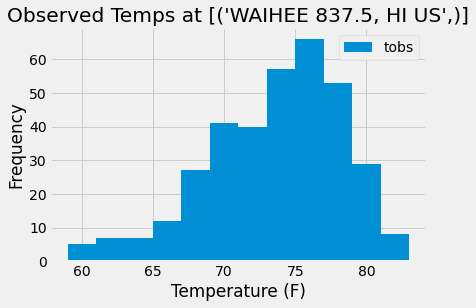

In [67]:
# Using the most active station id USC00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_station_tobs = session.query(measurement.date, measurement.tobs).filter(measurement.station == max_station).\
filter(measurement.date >= "2016-08-23").filter(measurement.date <= "2017-08-23").all()

max_station_tobs_df = pd.DataFrame(max_station_tobs, columns = ['date', 'tobs'])

plt.figure()
max_station_tobs_df.plot.hist(bins=12)
plt.title(f"Observed Temps at {max_station_name}")
plt.xlabel('Temperature (F)')



# Close session

In [66]:
# Close Session
session.close()